<a href="https://colab.research.google.com/gist/EdwinTSalcedo/2c37ee0bc29aa7e9e6e978417070c66e/contrast-limit-regular-histogram-equalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <h1><center>Contrast-Limit & Regular Histogram Equalisation</center></h1>
This notebook implements Histogram Equalisation (HE) and Contrast-Limit Histogram Equalisation (CLAHE) algorithms from scratch. Histogram Equalisation shows the same results as OpenCV's implementation, but CLAHE still requires interpolation processes to minimise the variance between the grid components. 

## 0. Import Libraries

In [91]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 1. Histogram Equalisation (HE)

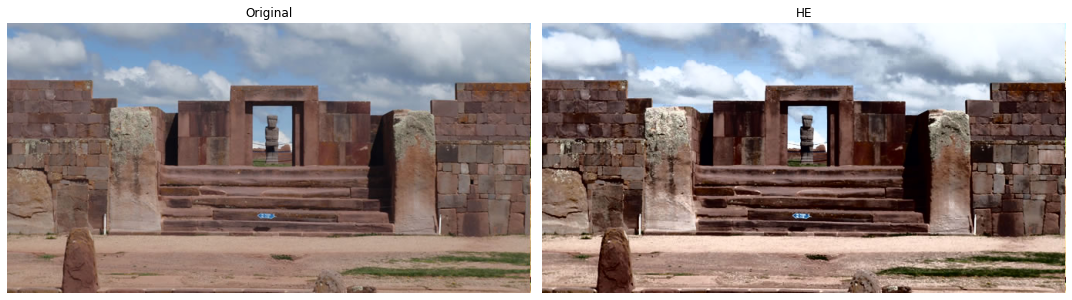

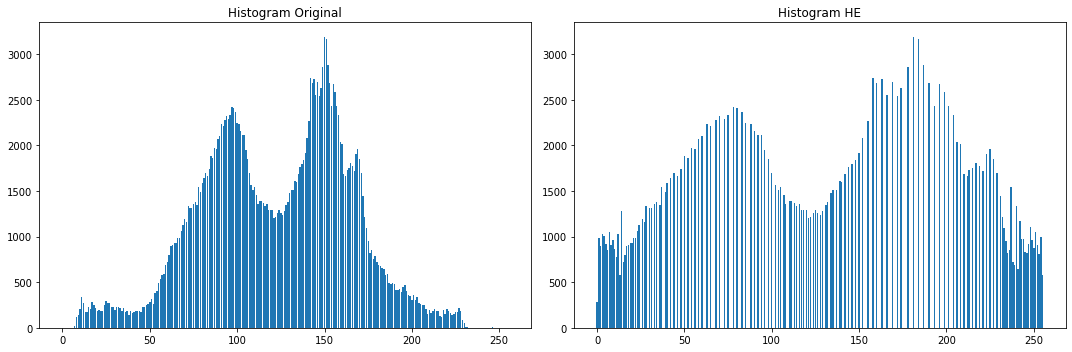

In [99]:
# Helper function to visualise a pair of images/plots
def visualise(inputs, titles, type):
  fig = plt.figure(figsize=(15,5))
  ax1 = plt.subplot(1, 2, 1)
  ax2 = plt.subplot(1, 2, 2)
  ax1.set_title(titles[0])
  ax2.set_title(titles[1])

  if type == "images":
    ax1.set_axis_off()
    ax1.imshow(inputs[0], cmap='gray')
    ax2.set_axis_off()
    ax2.imshow(inputs[1], cmap='gray')
  else: 
    ax1.bar(range(0, 256), inputs[0].reshape(-1))
    ax2.bar(range(0, 256), inputs[1].reshape(-1))

  fig.tight_layout()
  plt.show()

# Histogram Equalisation implementation
def equaliseHist(image):

  image_base = np.array(image, copy=True)
  
  # Convert image to YUV model colour and isolate the Y channel (Luminance)
  if len(image_base.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]

  grey_levels = 256 # L^n where L = 2 and n = 8 is the number of bits per pixel

  # Generate the intensity histogram for the image
  flatten = image.flatten()
  hist = np.full(grey_levels, 0)
  hist_alt = np.array(hist, copy=True)
  
  # Possible to optimise with -> hist, bin_edges = np.histogram(flatten,256)
  for i in range(len(flatten)): 
    hist[flatten[i]] = hist[flatten[i]] + 1 

  # Calculate the Probability Distribution Function (PDF), meaning 'Normalise' 
  pdf = hist/image.size

  # Calculate the Cumulate Distribution Function (CDF) 
  cdf = np.cumsum(pdf)

  # Equalise previous distribution and round it 
  new_distribution = (np.round(cdf*(grey_levels-1))).astype("uint8")
  
  alt_image = np.array(image, copy=True)

  # For each pixel, the intensity is converted into its new value according to 
  # the new distribution 
  for row in range(image.shape[0]):
    for col in range(image.shape[1]):
      alt_image[row, col] = new_distribution[image[row, col]] 
  
  # Calculate the histogram of the equalised image
  eq_flatten = alt_image.flatten()
  for i in range(len(eq_flatten)):
    hist_alt[eq_flatten[i]] = hist_alt[eq_flatten[i]] + 1
  
  # Inverse conversion from YUV to RGB if the input image was in colour mode
  if len(image_base.shape) > 2:
    image_aux = cv2.cvtColor(image_base, cv2.COLOR_RGB2YUV)
    image_aux[:,:,0] = alt_image
    alt_image = cv2.cvtColor(image_aux,cv2.COLOR_YUV2RGB)
    
  visualise([image_base,alt_image],["Original","HE"],"images")
  visualise([hist,hist_alt],["Histogram Original","Histogram HE"],"plots")
    
# Load the image
image = cv2.imread("tia.jpeg")
if len(image.shape) > 2:
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

equaliseHist(image)

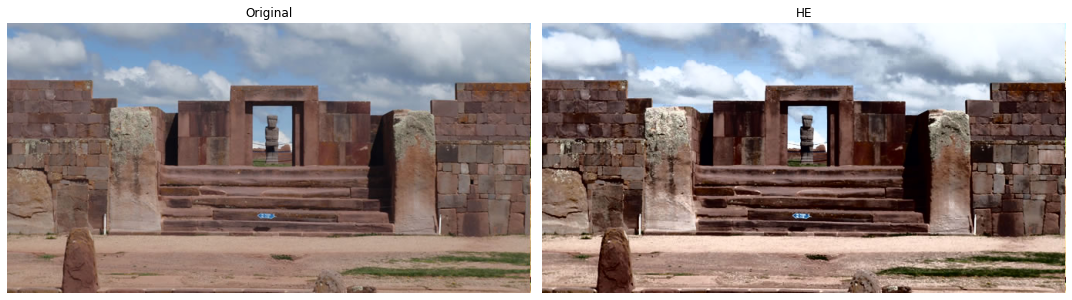

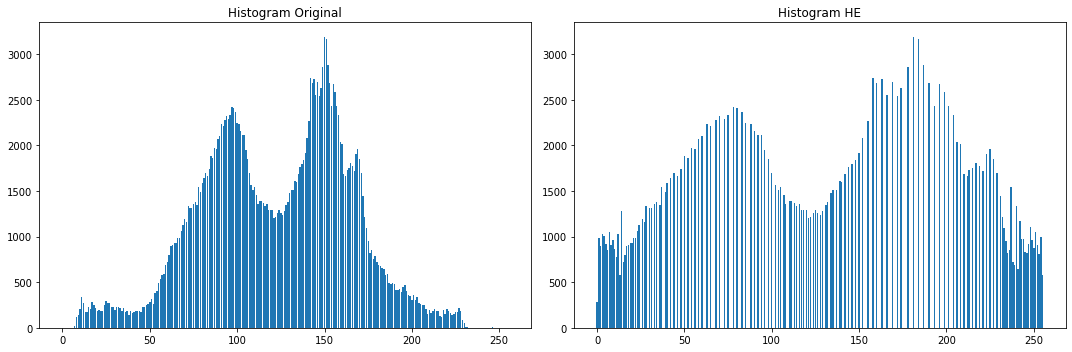

In [93]:
# Histogram Equalisation implementation with OpenCV
def equaliseHistOpenCV(image):
  image_base = np.array(image, copy=True)

  # Convert if it's an RGB image
  if len(image_base.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]

  equ = cv2.equalizeHist(image)
  hist = cv2.calcHist([image],[0],None,[256],[0,256])
  eq_hist = cv2.calcHist([equ],[0],None,[256],[0,256])

  # Inverse conversion from YUV to RGB
  if len(image_base.shape) > 2:
    image_aux = cv2.cvtColor(image_base, cv2.COLOR_RGB2YUV)
    image_aux[:,:,0] = equ
    equ = cv2.cvtColor(image_aux,cv2.COLOR_YUV2RGB)
  
  visualise([image_base,equ],["Original","HE"],"images")
  visualise([hist,eq_hist],["Histogram Original","Histogram HE"],"plots")

# Load the image
image = cv2.imread("tia.jpeg")
if len(image.shape) > 2:
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

equaliseHistOpenCV(image)

## 2. Contrast-Limit Histogram Equalisation (CLAHE)

In [100]:
# Function to equalise a single grid component
def equaliseTile(tile, clip_limit, grey_levels):
  
  hist = cv2.calcHist([tile], [0] ,None,[256],[0,256])
  # grey_levels = len(hist[hist !=0 ])
  grey_levels = 256

  # Contrast limit
  accum = 0
  for idx, count in enumerate(hist): 
    if count > clip_limit: 
      accum = accum + (clip_limit-count)
      hist[idx] = clip_limit
  
  contrast = np.max(tile)-np.min(tile)

  if contrast > 0:
    dist = int(accum/(grey_levels))
    
    for idx, count in enumerate(hist):
      hist[idx] += dist

  # Histogram Equalisation
  pdf = hist/tile.size 
  cdf = np.cumsum(pdf) 
  new_distribution = (np.round(cdf*(grey_levels-1))).astype("uint8")

  # gamma correction
  gamma = 50
  alt_tile = np.array(tile, copy=True)
  for row in range(tile.shape[0]):
    for col in range(tile.shape[1]):
      alt_tile[col, row] = new_distribution[tile[col, row]] + gamma

  # alt_tile = cv2.equalizeHist(tile) # Uncomment to check own HE implementation
  
  return alt_tile

(350, 680, 3)


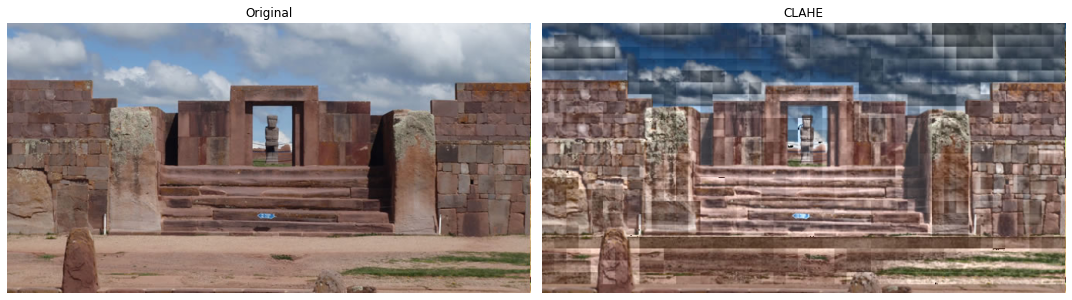

In [98]:
# CLAHE implementation
def equaliseCLAHE(image, clip_limit, tile_size):
  # Find dimensions
  image_base = np.array(image, copy=True)
  width_base = image.shape[0]
  height_base = image.shape[1]
  
  # Convert image to YUV mode
  if len(image_base.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]
  
  grey_levels = 256 # L^n where L = 2 and n = 8 is the number of bits per pixel
  
  # Create the grid of tiles
  extra_width = image.shape[0]%tile_size
  extra_height = image.shape[1]%tile_size

  image = cv2.resize(image, (image.shape[1]+extra_height, image.shape[0]+extra_width), interpolation = cv2.INTER_AREA)

  x = image.shape[0]//tile_size
  y = image.shape[1]//tile_size
  
  alt_image = np.array(image, copy=True)
  
  # Equalise tiles 
  for col in range(x):
    aux_cols = tile_size * col

    for row in range(y):
      aux_rows = tile_size * row
      tile = image[aux_cols:aux_cols+tile_size, aux_rows:aux_rows+tile_size]
      alt_image[aux_cols:aux_cols+tile_size, aux_rows:aux_rows+tile_size] = equaliseTile(tile,clip_limit,grey_levels)
    
  # Invert resizing 
  alt_image = cv2.resize(alt_image, (height_base, width_base), interpolation = cv2.INTER_AREA)

  if len(image_base.shape) > 2:
    image_aux = cv2.cvtColor(image_base, cv2.COLOR_RGB2YUV)
    image_aux[:,:,0] = alt_image
    alt_image = cv2.cvtColor(image_aux,cv2.COLOR_YUV2RGB)
  
  visualise([image_base,alt_image],["Original","CLAHE"],"images")

# Load the image
image = cv2.imread("tia.jpeg")
if len(image.shape) > 2:
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

equaliseCLAHE(image, 3, 16)

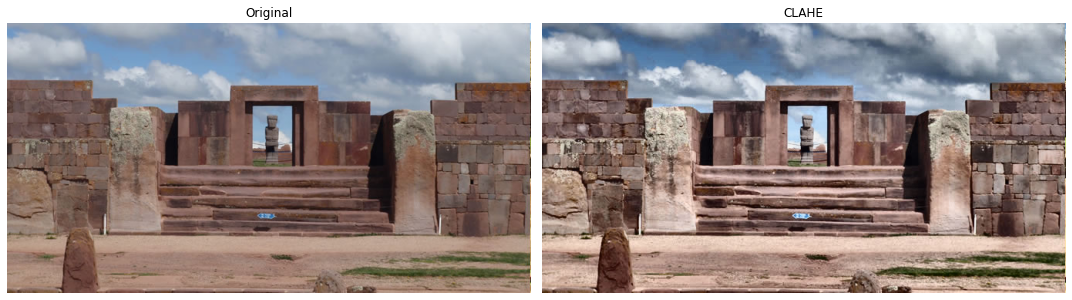

In [96]:
def equaliseCLAHEOpenCV(image):
  image_base = np.array(image, copy=True)

  # Convert if it's an RGB image
  if len(image_base.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl1 = clahe.apply(image)

  # Inverse conversion if it was an RGB image
  if len(image_base.shape) > 2:
    image_aux = cv2.cvtColor(image_base, cv2.COLOR_RGB2YUV)
    image_aux[:,:,0] = cl1
    cl1 = cv2.cvtColor(image_aux,cv2.COLOR_YUV2RGB)
  
  visualise([image_base,cl1],["Original","CLAHE"],"images")

# Load the image
image = cv2.imread("tia.jpeg")
if len(image.shape) > 2:
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

equaliseCLAHEOpenCV(image)

## 3. TO DO: 
- Interpolate better between neighbour tiles
- Remove gamma correction